In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import os
from dotenv import load_dotenv
from polygon import RESTClient
import json
import talib
load_dotenv() 


API_KEY = os.getenv("API_KEY")
client = RESTClient(api_key=API_KEY)


In [2]:
def get_stock_data(ticker, multiplier, timespan, from_, to, limit):
    aggs = []
    for a in client.list_aggs(ticker=ticker, multiplier=multiplier, timespan=timespan, from_=from_, to=to, limit=limit):
        aggs.append(a)
    df = pd.DataFrame(aggs)
    df['Date'] = df['timestamp'].apply(lambda x: pd.to_datetime(x*1000000))
    df.set_index('Date', inplace=True)  # Set 'Date' as the index here
    df = df.drop(columns=['otc', 'timestamp'])
    return df

df = get_stock_data('X:BTCUSD', 1, 'minute', '2024-04-04', '2024-04-05', 1000)
df

,open,high,low,close,volume,vwap,transactions
Date,,,,,,,
2024-04-04 00:00:00,65984.15,65991.40,65943.00,65982.23,2.759501,65970.8218,205
2024-04-04 00:01:00,65987.99,65998.30,65865.00,65913.89,17.135195,65916.9537,394
2024-04-04 00:02:00,65913.89,65921.50,65855.00,65867.11,5.893382,65896.2018,216
2024-04-04 00:03:00,65865.94,65922.74,65847.00,65894.04,10.366954,65877.9690,280
2024-04-04 00:04:00,65892.79,66064.85,65886.87,66031.87,19.444150,65959.8607,388
...,...,...,...,...,...,...,...
2024-04-05 23:55:00,67970.90,67971.00,67887.10,67895.73,17.598025,67926.7145,437
2024-04-05 23:56:00,67887.92,67905.62,67870.40,67887.48,5.574321,67889.1526,294
2024-04-05 23:57:00,67882.59,67893.30,67780.00,67813.09,3.978157,67835.2148,290


In [28]:
# df['SMA'] = talib.SMA(df['close'], timeperiod=20)

### Stoch

In [3]:
def calculate_stoch(dataframe, period):
    high_resampled = dataframe['high'].resample(f'{period}T').max()
    low_resampled = dataframe['low'].resample(f'{period}T').min()
    close_resampled = dataframe['close'].resample(f'{period}T').last()

    slowk, slowd = talib.STOCH(high_resampled, low_resampled, close_resampled, fastk_period=5, slowk_period=3, slowd_period=3)
    return slowk, slowd

# Calculate Stochastic for 15, 30, 45, and 60-minute timeframes
stoch_15k, stoch_15d = calculate_stoch(df, 15)
stoch_30k, stoch_30d = calculate_stoch(df, 30)
stoch_45k, stoch_45d = calculate_stoch(df, 45)
stoch_60k, stoch_60d = calculate_stoch(df, 60)

# Combining results back into the original dataframe (using forward fill for NaNs)
df['stoch_15k'] = stoch_15k.reindex(df.index, method='ffill')
df['stoch_15d'] = stoch_15d.reindex(df.index, method='ffill')
df['stoch_30k'] = stoch_30k.reindex(df.index, method='ffill')
df['stoch_30d'] = stoch_30d.reindex(df.index, method='ffill')
df['stoch_45k'] = stoch_45k.reindex(df.index, method='ffill')
df['stoch_45d'] = stoch_45d.reindex(df.index, method='ffill')
df['stoch_60k'] = stoch_60k.reindex(df.index, method='ffill')
df['stoch_60d'] = stoch_60d.reindex(df.index, method='ffill')

### Visualize Stoch

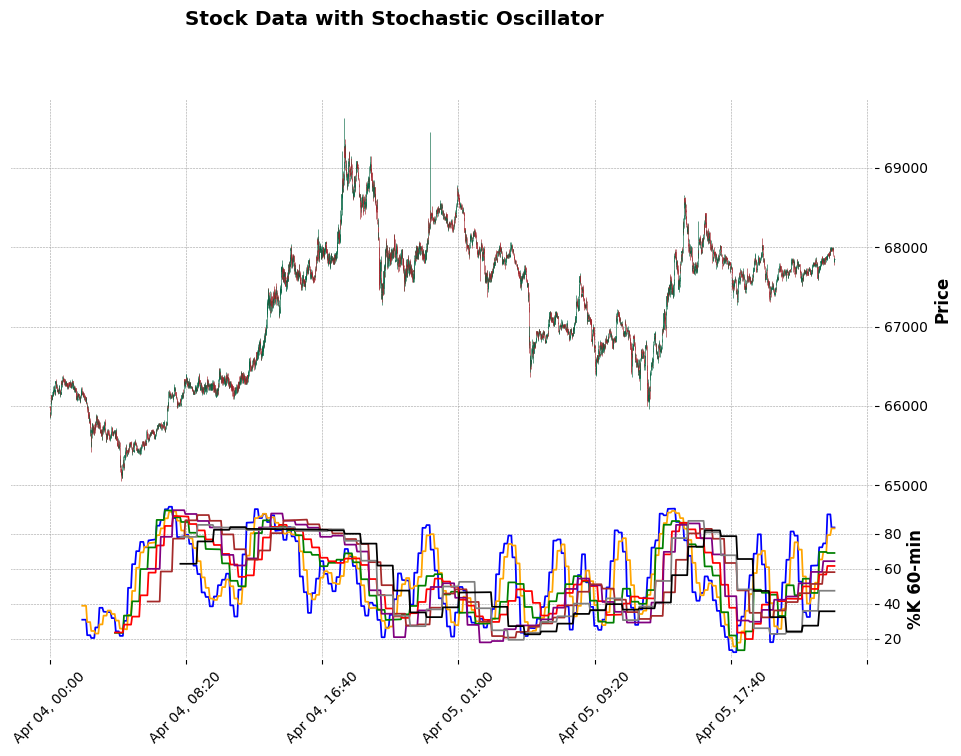

In [11]:
stoch_oscillator = [
    mpf.make_addplot(df['stoch_15k'], panel=1, color='blue', ylabel='%K 15-min'),
    mpf.make_addplot(df['stoch_15d'], panel=1, color='orange'),
    mpf.make_addplot(df['stoch_30k'], panel=1, color='green', ylabel='%K 30-min'),
    mpf.make_addplot(df['stoch_30d'], panel=1, color='red'),
    mpf.make_addplot(df['stoch_45k'], panel=1, color='purple', ylabel='%K 45-min'),
    mpf.make_addplot(df['stoch_45d'], panel=1, color='brown'),
    mpf.make_addplot(df['stoch_60k'], panel=1, color='gray', ylabel='%K 60-min'),
    mpf.make_addplot(df['stoch_60d'], panel=1, color='black'),
]

# Use mplfinance to plot the candlestick chart and the Stochastic oscillator on separate panels
mpf.plot(df, type='candle', style='charles', addplot=stoch_oscillator, volume=False, figsize=(12, 8), title="Stock Data with Stochastic Oscillator")

### William Fractals

In [4]:
def calculate_fractals(df):
    highs = df['high']
    lows = df['low']
    
    # Identify potential fractals
    is_fractal_high = (highs.shift(1) < highs) & (highs.shift(-1) < highs)
    is_fractal_low = (lows.shift(1) > lows) & (lows.shift(-1) > lows)
    
    df['fractal_highs'] = np.where(is_fractal_high, highs, np.nan)
    df['fractal_lows'] = np.where(is_fractal_low, lows, np.nan)
    
    return df
# Calculate fractals

df = calculate_fractals(df)
df

,open,high,low,close,volume,vwap,transactions,stoch_15k,stoch_15d,stoch_30k,stoch_30d,stoch_45k,stoch_45d,stoch_60k,stoch_60d,fractal_highs,fractal_lows
Date,,,,,,,,,,,,,,,,,
2024-04-04 00:00:00,65984.15,65991.40,65943.00,65982.23,2.759501,65970.8218,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-04 00:01:00,65987.99,65998.30,65865.00,65913.89,17.135195,65916.9537,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65998.3,NaN
2024-04-04 00:02:00,65913.89,65921.50,65855.00,65867.11,5.893382,65896.2018,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-04 00:03:00,65865.94,65922.74,65847.00,65894.04,10.366954,65877.9690,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65847.0
2024-04-04 00:04:00,65892.79,66064.85,65886.87,66031.87,19.444150,65959.8607,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05 23:55:00,67970.90,67971.00,67887.10,67895.73,17.598025,67926.7145,437,83.679631,83.133941,69.080208,61.66558,64.407194,58.131706,47.489047,35.750448,NaN,NaN
2024-04-05 23:56:00,67887.92,67905.62,67870.40,67887.48,5.574321,67889.1526,294,83.679631,83.133941,69.080208,61.66558,64.407194,58.131706,47.489047,35.750448,NaN,NaN
2024-04-05 23:57:00,67882.59,67893.30,67780.00,67813.09,3.978157,67835.2148,290,83.679631,83.133941,69.080208,61.66558,64.407194,58.131706,47.489047,35.750448,NaN,67780.0


### Visualize Fractals

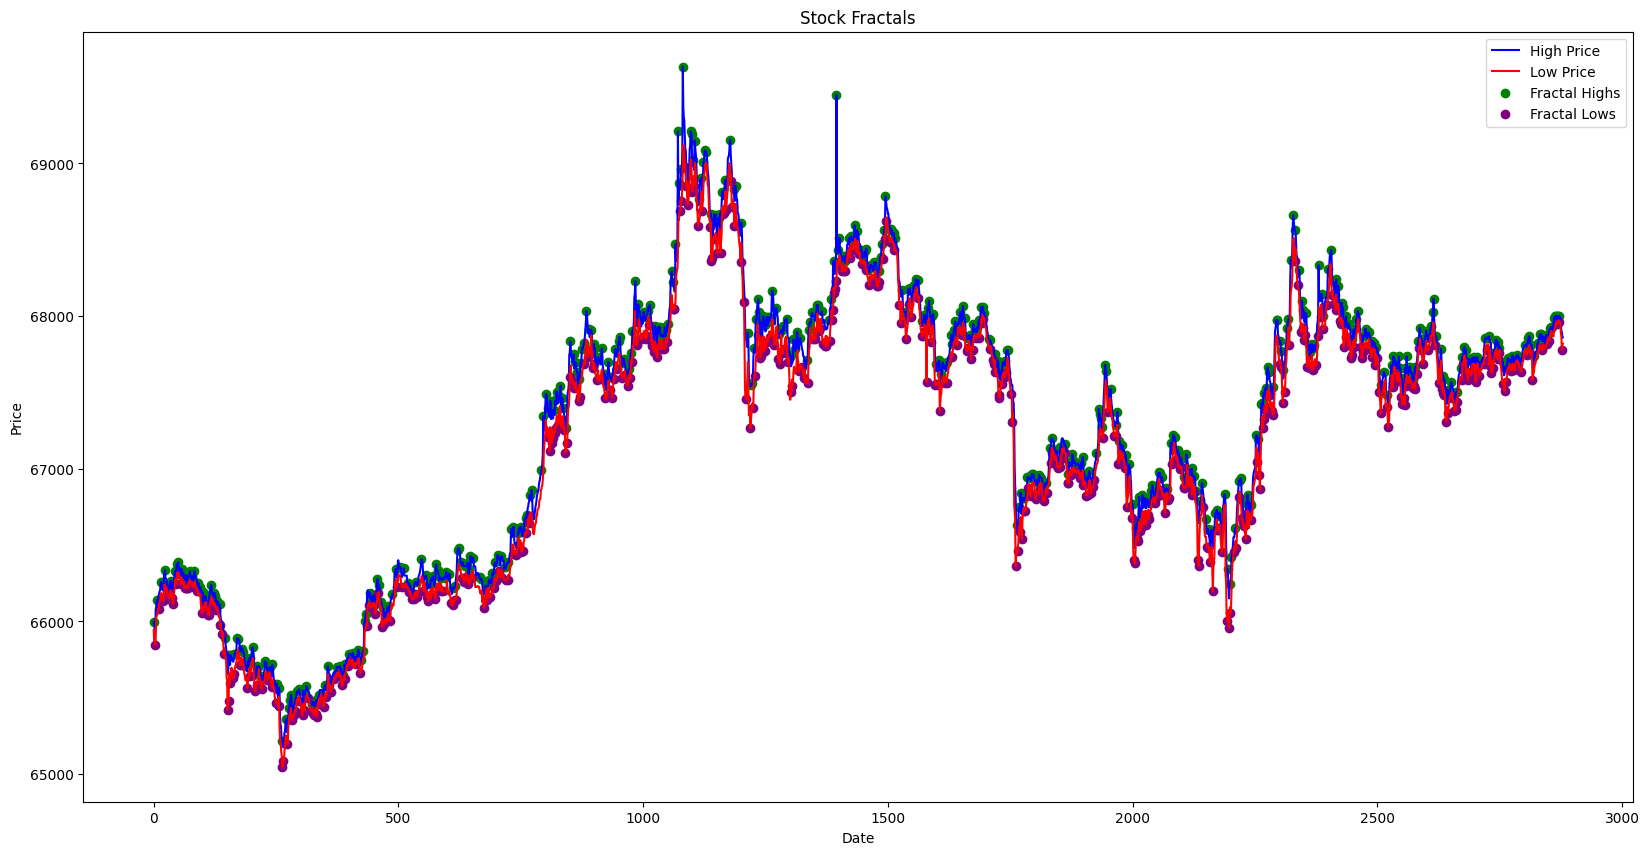

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(df['high'], label='High Price', color='blue')
plt.plot(df['low'], label='Low Price', color='red')
plt.scatter(df.index, df['fractal_highs'], color='green', label='Fractal Highs')
plt.scatter(df.index, df['fractal_lows'], color='purple', label='Fractal Lows')
plt.title('Stock Fractals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Fibonacci Retracement

In [31]:
def fibonacci_retracement(df):
    max_fractal_high = df['fractal_highs'].tail(120).max()
    min_fractal_low = df['fractal_lows'].tail(120).min()
    
    # Calculate the different etween high and low
    price_range = max_fractal_high - min_fractal_low
    
    #calculate retracement levels
    retracement_minus_23_6 = max_fractal_high + 0.236 * price_range
    retracement_0 = max_fractal_high
    retracement_23_6 = max_fractal_high - 0.236 * price_range
    retracement_38_2 = max_fractal_high - 0.382 * price_range
    retracement_50 = max_fractal_high - 0.5 * price_range
    retracement_61_8 = max_fractal_high - 0.618 * price_range
    retracement_78_6 = max_fractal_high - 0.786 * price_range
    retracement_100 = min_fractal_low
    
    # Create dict tos tore levels
    retracement_levels = {
        '-0.236': retracement_minus_23_6,
        '0': retracement_0,
        '0.236': retracement_23_6,
        '0.382': retracement_38_2,
        '0.5': retracement_50,
        '0.618': retracement_61_8,
        '0.786': retracement_78_6,
        '1': retracement_100,
    }
    
    return retracement_levels

retracement_levels = fibonacci_retracement(df)

#display levels
for level, price in retracement_levels.items():
    print(f'{level}: {price}')

-0.236: 68115.63764
0: 68000.0
0.236: 67884.36236
0.382: 67812.82382
0.5: 67755.005
0.618: 67697.18617999999
0.786: 67614.86786
1: 67510.01


### Visualize Fib

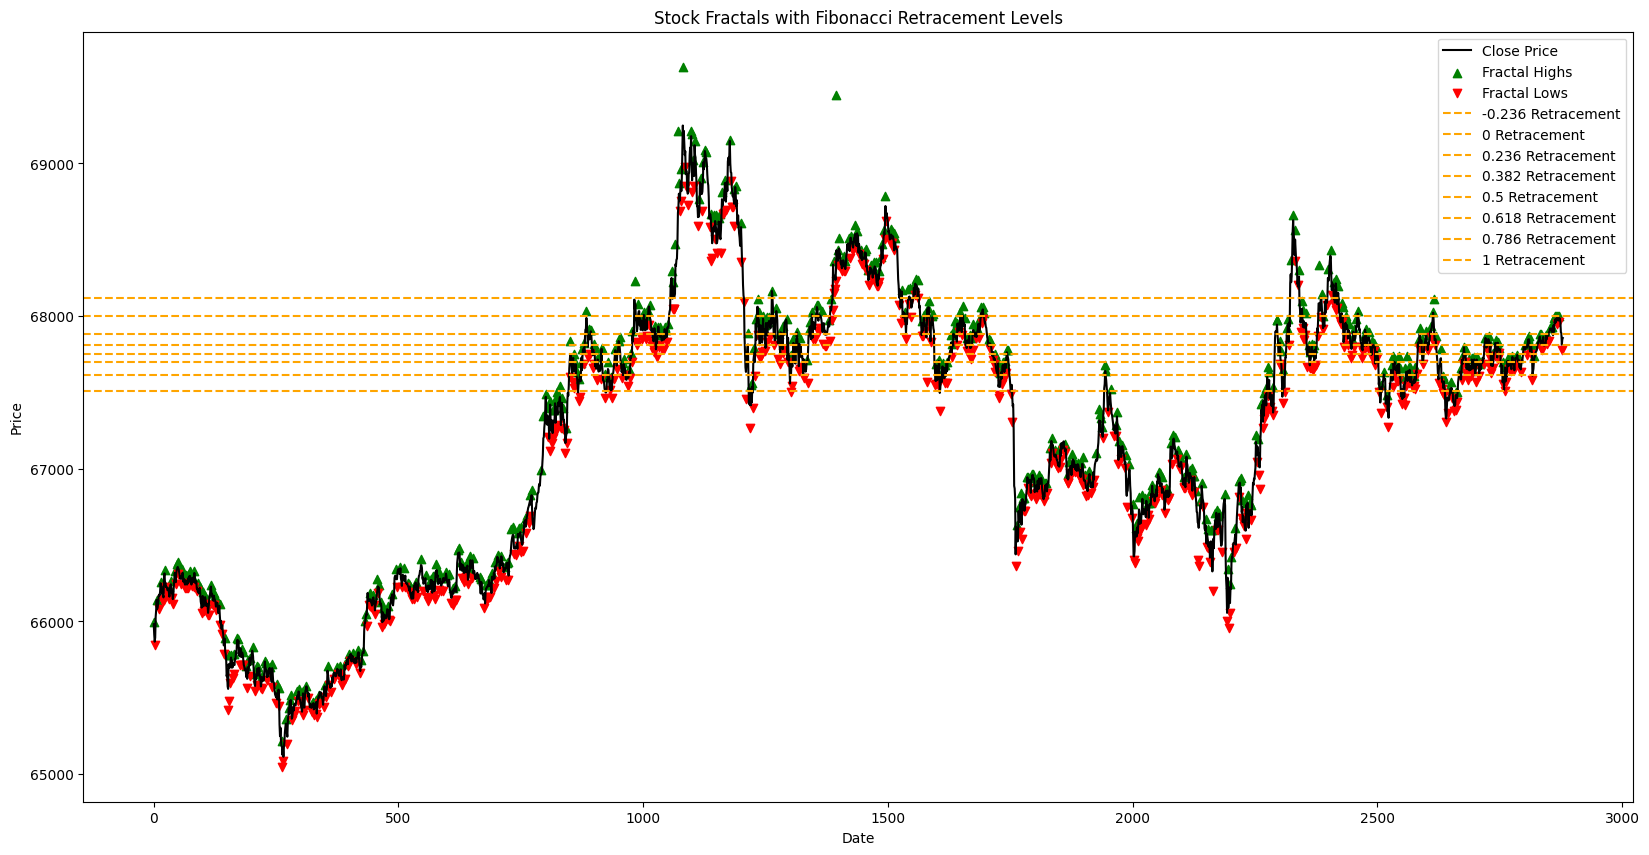

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(df['close'], label='Close Price', color='black')
plt.scatter(df.index, df['fractal_highs'], marker='^', color='green', label='Fractal Highs')
plt.scatter(df.index, df['fractal_lows'], marker='v', color='red', label='Fractal Lows')

for level, price in retracement_levels.items():
    plt.axhline(y=price, color='orange', linestyle='--', label=f'{level} Retracement')
plt.title('Stock Fractals with Fibonacci Retracement Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show() 


USE moving averages: if moving average is decreasing, fibonacci is reversed